In [1]:
from src.my_crossover import MyCrossover
from src.my_generator import MyGenerator
from src.my_mutation import MyMutation
from src.my_selector import MySelector
from src.fitness_function import FitnessFunction
from src.candidate import Candidate
import gc

##########################

import typing
from time import time
from typing_extensions import List
import random
import numba
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy, copy
import numpy as np
import optuna
from numba.typed import List as NumbaList
from numba.experimental import jitclass
from numba import jit

#### Перебор параметров эволюционного алгоритма

In [2]:
@jit(nopython=True)
def evaluate(dim: int, pop_size: int, iters: int, trials: int, cross_pairs: int, 
             cross_gene_opt_prob: float, mut_gene_opt_prob: float, mut_gauss_sigma:float,
             mut_cand_prob: float, mut_gene_prob: float, gen_mode: int, alg_mode: int, mut_mode: int) -> List[float]:
    best_fitnesses, best_iters = [], []
    for _ in range(trials):

        # Инициализация операторов эволюционного процесса
        ff = FitnessFunction(dim)
        generator = MyGenerator(dim, gen_mode, 5)
        selection_oprt = MySelector(pop_size)

        if alg_mode in [0,2]:
            crossover_oprt = MyCrossover(dim, cross_pairs, cross_gene_opt_prob)
        if alg_mode in [0,1]:
            mutate_oprt = MyMutation(dim, mut_cand_prob, mut_gene_prob, 
                                 mut_gene_opt_prob, mut_gauss_sigma, mut_mode)
        
        #print("Инициализация популяции")
        base_pop = generator.get_population(pop_size)

        #print("Старт эволюционного процесса...")
        cur_fitness = []
        for iter_idx in range(iters):

            #print("Проверка критерия останова...")
            if ff.best_result >= 9.9:
                cur_fitness.append(ff.best_result)
                #print("Достаточно-хорошее решение найдено!")
                break
            
            #
            union_pop, union_fit = [], []

            # use both mutation and crossover operators
            if alg_mode == 0: 
                #print(f"Мутация {len(base_pop)} кандидатов...")
                old_pop = mutate_oprt.apply(base_pop)
                old_fit = [ff.calculate_fitness(sol) for sol in old_pop]

                union_pop += old_pop
                union_fit += old_fit

                #print(f"Кроссовер {len(union_pop)} кандидатов...")
                new_pop = crossover_oprt.mate(union_pop, union_fit)
                new_fit = [ff.calculate_fitness(sol) for sol in new_pop]

                union_pop += new_pop
                union_fit += new_fit
                
            # use only mutation operator
            elif alg_mode == 1: 
                #print(f"Мутация {len(base_pop)} кандидатов...")
                pop = mutate_oprt.apply(base_pop)
                fit = [ff.calculate_fitness(sol) for sol in pop]

                union_pop += pop
                union_fit += fit
            
            # use only crossover operator
            elif alg_mode == 2:
                #print(f"Кроссовер {len(union_pop)} кандидатов...")
                base_fit = [ff.calculate_fitness(sol) for sol in base_pop]
                
                for p_item, f_item in zip(base_pop, base_fit):
                    union_pop.append(p_item)
                    union_fit.append(f_item)

                pop = crossover_oprt.mate(base_pop, base_fit)
                fit = [ff.calculate_fitness(sol) for sol in pop]

                union_pop += pop
                union_fit += fit

            else:
                raise KeyError

            #print("Селекция кандидатов...")
            base_pop = selection_oprt.filter_population(union_pop, union_fit)

            cur_fitness.append(ff.best_result)

        best_fitnesses.append(cur_fitness)
        best_iters.append(iter_idx+1)

    return best_fitnesses, best_iters

In [3]:
def objective(trial):
    global DIMENSION
    global EVALALG_ITERATIONS
    global EVALALG_TRIALS
    global ALG_MODE
    global POPULATION_SIZE

    population_size = POPULATION_SIZE
    generation_mode = trial.suggest_categorical("generation_mode", [0, 1, 2])
    algorithm_mode = ALG_MODE

    mutation_cand_prob, mutation_gene_prob, mutation_gene_operation_prob, mutation_gauss_sigma, mutation_mode = -1,-1,-1,-1, -1
    crossover_pairs, crossover_gene_operation_prob = -1, -1
    
    #
    if algorithm_mode in [0,1]:
        mutation_cand_prob = trial.suggest_float("mutation_cand_prob", 0, 1, step=0.05)
        mutation_gene_prob = trial.suggest_float("mutation_gene_prob", 0, 1, step=0.05)
        mutation_gene_operation_prob = trial.suggest_float("mutation_gene_operation_prob", 0, 1, step=0.05)
        mutation_gauss_sigma = trial.suggest_float("mutation_gauss_sigma", 0, 3, step=0.2)
        mutation_mode = trial.suggest_categorical("mutation_mode", [0, 1])

    #
    if algorithm_mode in [0,2]:
        crossover_pairs = trial.suggest_int("crossover_pairs", 0, population_size, step=5)
        crossover_gene_operation_prob = trial.suggest_float("crossover_gene_operation_prob", 0, 1, step=0.05)

    #
    best_fitnesses, best_iters = evaluate(DIMENSION, population_size, EVALALG_ITERATIONS, EVALALG_TRIALS, crossover_pairs, 
             crossover_gene_operation_prob, mutation_gene_operation_prob, mutation_gauss_sigma,
             mutation_cand_prob, mutation_gene_prob, generation_mode, algorithm_mode, mutation_mode)

    mean_fitness = np.mean(list(map(lambda smpl: smpl[-1], best_fitnesses)))
    mean_iters = np.mean(best_iters)

    return mean_fitness, mean_iters

In [4]:
CONFIGS = [
    [2,5,'2d', 50],
    [10,5,'10d', 50],
    [20,5,'20d', 50],
    [50,5,'50d', 50],
    [100,5,'100d', 50]
]

In [ ]:
for dim, evalalg_trials, save_prefix, optuna_trials in CONFIGS:

    DIMENSION = dim
    EVALALG_TRIALS = evalalg_trials
    EVALALG_ITERATIONS = 9999
    POPULATION_SIZE = 99
    ALG_MODE = 0

    print(DIMENSION, EVALALG_ITERATIONS, EVALALG_TRIALS)

    study = optuna.create_study(directions=['maximize', 'minimize'])
    study.optimize(objective, n_trials=optuna_trials, show_progress_bar=True)

    joblib.dump(study, f"./{save_prefix}_optuna_study.pkl")

#### Ручной запуск лучших решений

In [5]:
best_params = {
    2: {'crossover_pairs': 55, 'crossover_gene_operation_prob': 0.95, 'mutation_gene_operation_prob': 0.7, 'mutation_gauss_sigma': 1.6,
        'mutation_cand_prob': 0.3, 'mutation_gene_prob': 0.2, 'generation_mode': 0, 'mutation_mode': 1},

    10: {'crossover_pairs': 85, 'crossover_gene_operation_prob': 0.3, 'mutation_gene_operation_prob': 0.95, 'mutation_gauss_sigma': 2.2,
        'mutation_cand_prob': 0.2, 'mutation_gene_prob': 0.8, 'generation_mode': 0, 'mutation_mode': 1},

    20: {'crossover_pairs': 60, 'crossover_gene_operation_prob': 0.2, 'mutation_gene_operation_prob': 0.65, 'mutation_gauss_sigma': 2.0,
        'mutation_cand_prob': 1.0, 'mutation_gene_prob': 0.35, 'generation_mode': 0, 'mutation_mode': 1},

    50: {'crossover_pairs': 95, 'crossover_gene_operation_prob': 0.25, 'mutation_gene_operation_prob': 0.15, 'mutation_gauss_sigma': 1.0,
        'mutation_cand_prob': 0.65, 'mutation_gene_prob': 0.75, 'generation_mode': 1, 'mutation_mode': 1},
        
    100: {'crossover_pairs': 80, 'crossover_gene_operation_prob': 0.2, 'mutation_gene_operation_prob': 0.05, 'mutation_gauss_sigma': 2.0,
        'mutation_cand_prob': 0.3, 'mutation_gene_prob': 0.9, 'generation_mode': 1, 'mutation_mode': 1},
}

#
ITERATIONS = 10000
POPULATION_SIZE = 99
TRIALS = 5

Размерность решения:  2


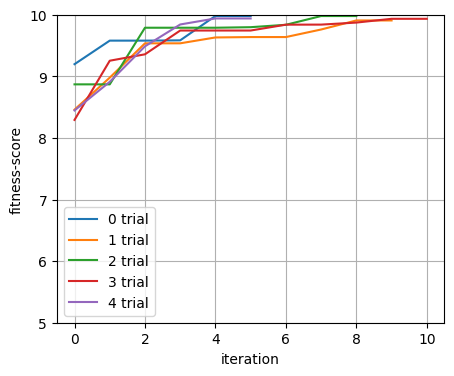

Mean fitness/iterations: 9.947760391235352/8.4
Размерность решения:  10


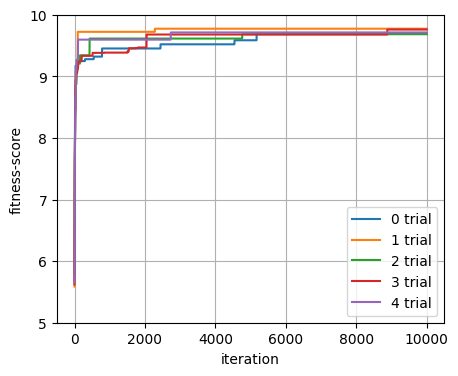

Mean fitness/iterations: 9.725543594360351/10000.0
Размерность решения:  20


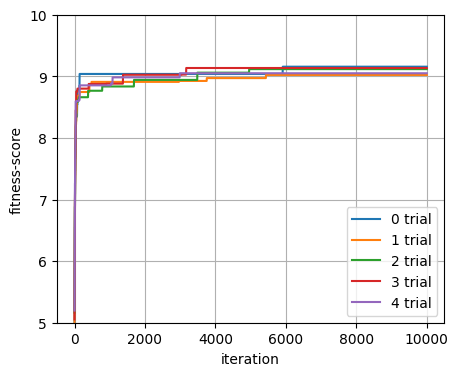

Mean fitness/iterations: 9.096129226684571/10000.0
Размерность решения:  50


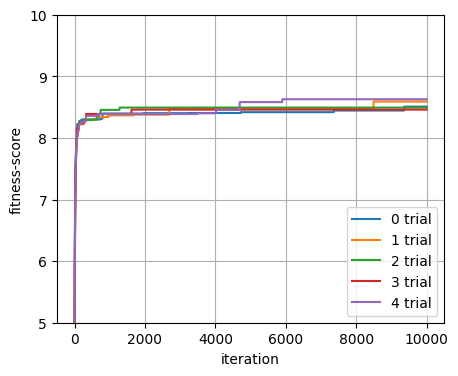

Mean fitness/iterations: 8.53572769165039/10000.0
Размерность решения:  100


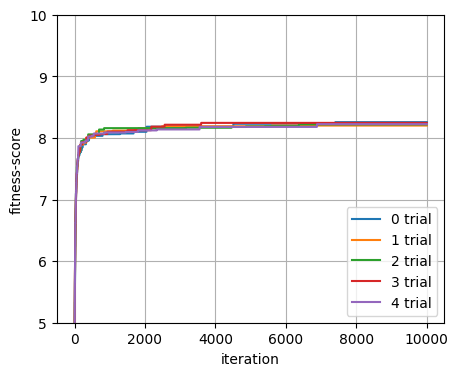

Mean fitness/iterations: 8.228775787353516/10000.0


In [9]:
for cur_dim, params in best_params.items():
    print("Размерность решения: ", cur_dim)
    gc.collect()

    best_fitnesses, best_iters = evaluate(cur_dim, POPULATION_SIZE, ITERATIONS, TRIALS, params['crossover_pairs'], 
                params['crossover_gene_operation_prob'], params['mutation_gene_operation_prob'], params['mutation_gauss_sigma'],
                params['mutation_cand_prob'], params['mutation_gene_prob'], params['generation_mode'], 0, params['mutation_mode'])

    plt.figure(figsize=(5,4))

    for i, fitness in enumerate(best_fitnesses):
        plt.plot(list(range(len(fitness))), fitness, label=f"{i} trial")

    plt.xlabel("iteration")
    plt.ylim([5, 10])
    plt.ylabel("fitness-score")
    plt.legend()
    plt.grid()
    plt.show()

    mean_fitness = np.mean(list(map(lambda smpl: smpl[-1], best_fitnesses)))
    mean_iters = np.mean(best_iters)

    print(f"Mean fitness/iterations: {mean_fitness}/{mean_iters}")

### Оценки

#### Зависимость производительности/эффективности алгоритма от размера популяции

In [8]:
DIM = [2,10,20,50,100]
POPULATION_SIZE = list(range(100, 2600, 500))
EVALALG_ITERATIONS = 9999
EVALALG_TRIALS = 5

pop_info = {v: [] for v in DIM}
for cur_dim in DIM:
    
    dim_info = []
    params = best_params[cur_dim]
    process = tqdm(POPULATION_SIZE)
    gc.collect()
    
    for cur_pop_size in process:
        gc.collect()
        
        s_time = time()
        best_fitnesses, best_iters = evaluate(cur_dim, cur_pop_size, EVALALG_ITERATIONS, EVALALG_TRIALS, params['crossover_pairs'], 
             params['crossover_gene_operation_prob'], params['mutation_gene_operation_prob'], params['mutation_gauss_sigma'],
             params['mutation_cand_prob'], params['mutation_gene_prob'], params['generation_mode'], 0, params['mutation_mode'])
        e_time = time()
        
        mean_fitness = np.mean(list(map(lambda smpl: smpl[-1], best_fitnesses)))
        mean_iters = np.mean(best_iters)
        elapsed_t = round(e_time - s_time, 5)

        pop_info[cur_dim].append((cur_pop_size, mean_fitness, mean_iters, elapsed_t))
        process.set_postfix({'fit': mean_fitness, 'iters': mean_iters, 'time': elapsed_t, 
                             'dim': cur_dim, 'pop_size': cur_pop_size})


100%|██████████| 5/5 [1:00:33<00:00, 726.63s/it, fit=8.32, iters=1e+4, time=1.47e+3, dim=100, pop_size=2100]


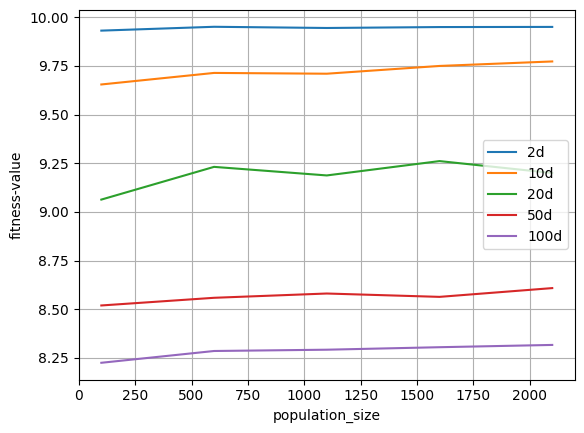

In [20]:
# draw graphs

#plt.figure(figsize=(5,5))

for info in pop_info.items():
    x = list(map(lambda v: v[0], info[1]))
    y = list(map(lambda v: v[1], info[1]))
    plt.plot(x, y, label=f"{info[0]}d")

plt.grid()
plt.ylabel("fitness-value")
plt.xlabel("population_size")
plt.legend()
plt.savefig("pop_fit_compare.jpeg")
plt.show()

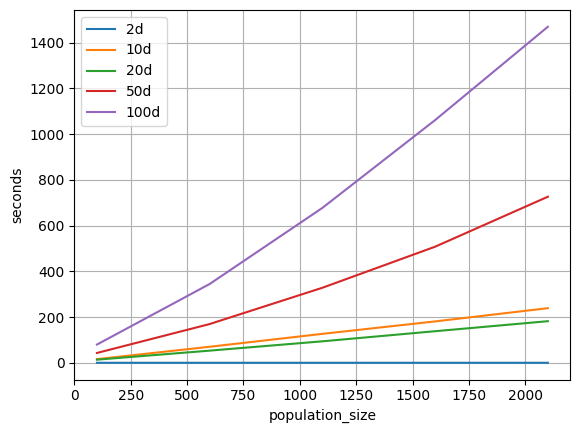

In [21]:
#plt.figure(figsize=(5,4))

for info in pop_info.items():
    x = list(map(lambda v: v[0], info[1]))
    y = list(map(lambda v: v[3], info[1]))
    plt.plot(x, y, label=f"{info[0]}d")

plt.grid()
plt.legend()
plt.ylabel("seconds")
plt.xlabel("population_size")
plt.savefig("pop_time_compare.jpeg")
plt.show()

#### Эволюционный алгоритм "без мутации"/"без кроссовера"

In [ ]:
for dim, evalalg_trials, save_prefix, optuna_trials in CONFIGS:

    DIMENSION = dim
    EVALALG_TRIALS = evalalg_trials
    EVALALG_ITERATIONS = 9999
    POPULATION_SIZE = 99

    for cur_alg_mode in [1,2]:
        ALG_MODE = cur_alg_mode

        print(DIMENSION, EVALALG_ITERATIONS, EVALALG_TRIALS, ALG_MODE)

        study = optuna.create_study(directions=['maximize', 'minimize'])
        study.optimize(objective, n_trials=optuna_trials, show_progress_bar=True)

        joblib.dump(study, f"./{save_prefix}_algmode{ALG_MODE}_optuna_study.pkl")

In [ ]:
best_params = {
    2: {
        1: {'crossover_pairs': None, 'crossover_gene_operation_prob': None, 'mutation_gene_operation_prob': None, 'mutation_gauss_sigma': None,
            'mutation_cand_prob': None, 'mutation_gene_prob': None, 'generation_mode': None, 'mutation_mode': None},
        2: {'crossover_pairs': None, 'crossover_gene_operation_prob': None, 'mutation_gene_operation_prob': None, 'mutation_gauss_sigma': None,
            'mutation_cand_prob': None, 'mutation_gene_prob': None, 'generation_mode': None, 'mutation_mode': None}},

    10: {
        1: {'crossover_pairs': None, 'crossover_gene_operation_prob': None, 'mutation_gene_operation_prob': None, 'mutation_gauss_sigma': None,
            'mutation_cand_prob': None, 'mutation_gene_prob': None, 'generation_mode': None, 'mutation_mode': None},
        2: {'crossover_pairs': None, 'crossover_gene_operation_prob': None, 'mutation_gene_operation_prob': None, 'mutation_gauss_sigma': None,
            'mutation_cand_prob': None, 'mutation_gene_prob': None, 'generation_mode': None, 'mutation_mode': None}},

    20: {
        1: {'crossover_pairs': None, 'crossover_gene_operation_prob': None, 'mutation_gene_operation_prob': None, 'mutation_gauss_sigma': None,
            'mutation_cand_prob': None, 'mutation_gene_prob': None, 'generation_mode': None, 'mutation_mode': None},
        2: {'crossover_pairs': None, 'crossover_gene_operation_prob': None, 'mutation_gene_operation_prob': None, 'mutation_gauss_sigma': None,
            'mutation_cand_prob': None, 'mutation_gene_prob': None, 'generation_mode': None, 'mutation_mode': None}},

    50: {
        1: {'crossover_pairs': None, 'crossover_gene_operation_prob': None, 'mutation_gene_operation_prob': None, 'mutation_gauss_sigma': None,
            'mutation_cand_prob': None, 'mutation_gene_prob': None, 'generation_mode': None, 'mutation_mode': None},
        2: {'crossover_pairs': None, 'crossover_gene_operation_prob': None, 'mutation_gene_operation_prob': None, 'mutation_gauss_sigma': None,
            'mutation_cand_prob': None, 'mutation_gene_prob': None, 'generation_mode': None, 'mutation_mode': None}},
        
    100: {
        1: {'crossover_pairs': None, 'crossover_gene_operation_prob': None, 'mutation_gene_operation_prob': None, 'mutation_gauss_sigma': None,
            'mutation_cand_prob': None, 'mutation_gene_prob': None, 'generation_mode': None, 'mutation_mode': None},
        2: {'crossover_pairs': None, 'crossover_gene_operation_prob': None, 'mutation_gene_operation_prob': None, 'mutation_gauss_sigma': None,
            'mutation_cand_prob': None, 'mutation_gene_prob': None, 'generation_mode': None, 'mutation_mode': None}},
}

In [ ]:
DIM = [2,10,20,50,100]
POPULATION_SIZE = 99
EVALALG_ITERATIONS = 9999
EVALALG_TRIALS = 5
ALG_MODE = [1,2]

opt_info = {v: {a_mode: [] for a_mode in ALG_MODE} for v in DIM}

process = tqdm(DIM)
for cur_dim in process:
    gc.collect()

    for cur_alg_mode in ALG_MODE:
        params = best_params[cur_dim][cur_alg_mode]

        s_time = time()
        best_fitnesses, best_iters = evaluate(
            cur_dim, POPULATION_SIZE, EVALALG_ITERATIONS, EVALALG_TRIALS, params['crossover_pairs'], 
            params['crossover_gene_operation_prob'], params['mutation_gene_operation_prob'], params['mutation_gauss_sigma'],
            params['mutation_cand_prob'], params['mutation_gene_prob'], params['generation_mode'], cur_alg_mode, params['mutation_mode'])
        e_time = time()
        
        mean_fitness = np.mean(list(map(lambda smpl: smpl[-1], best_fitnesses)))
        mean_iters = np.mean(best_iters)
        elapsed_t = round(e_time - s_time, 5)

        opt_info[cur_dim][cur_alg_mode].append(tuple(mean_fitness, mean_iters, elapsed_t))
        process.set_postfix({'fit': mean_fitness, 'iters': mean_iters, 'time': elapsed_t, 
                            'dim': cur_dim, 'alg_mode': cur_alg_mode})



In [ ]:
# draw graphs